In [1]:
# Import everything
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import rangelib
import shapely

# Generate maps that we will use later
FILE_DIR = os.path.dirname(os.path.realpath(os.path.abspath('')))
MAPS_FILE_PATH = os.path.join(FILE_DIR, "maps/tests")

MAP_SIZE = 600  # we want 600x600 square maps

# A corridor-shaped map
corridor_map = np.zeros((MAP_SIZE, MAP_SIZE), dtype=np.uint8)
corridor_map[150:450, :] = 255
CORRIDOR_MAP = os.path.join(MAPS_FILE_PATH, "corridor.png")
Image.fromarray(corridor_map).save(CORRIDOR_MAP)
CORRIDOR_MAP_OBSTACLES = [
    shapely.Polygon([(0, 0), (599, 0), (599, 150), (0, 150)]),
    shapely.Polygon([(0, 450), (599, 450), (599, 599), (0, 599)]),
]

# A map with boxes on all 4 corners
box_map = np.zeros((MAP_SIZE, MAP_SIZE), dtype=np.uint8)
box_map[50:550, 50:550] = 255
BOX_MAP = os.path.join(MAPS_FILE_PATH, "box.png")
Image.fromarray(box_map).save(BOX_MAP)

BOX_MAP_OBSTACLES = [
    shapely.Polygon([(0, 0), (599, 0), (599, 50), (0, 50)]),
    shapely.Polygon([(0, 0), (50, 0), (50, 599), (0, 599)]),
    shapely.Polygon([(0, 550), (599, 550), (599, 599), (0, 599)]),
    shapely.Polygon([(550, 0), (550, 599), (599, 599), (599, 0)]),
]

# A map with a corner
corner_map = np.zeros((MAP_SIZE, MAP_SIZE), dtype=np.uint8)
corner_map[150:450, 150:450] = 255
corner_map[150:450, 0:150] = 255
corner_map[450:, 150:450] = 255
Image.fromarray(corner_map).save(
    os.path.join(MAPS_FILE_PATH, "corner.png"))

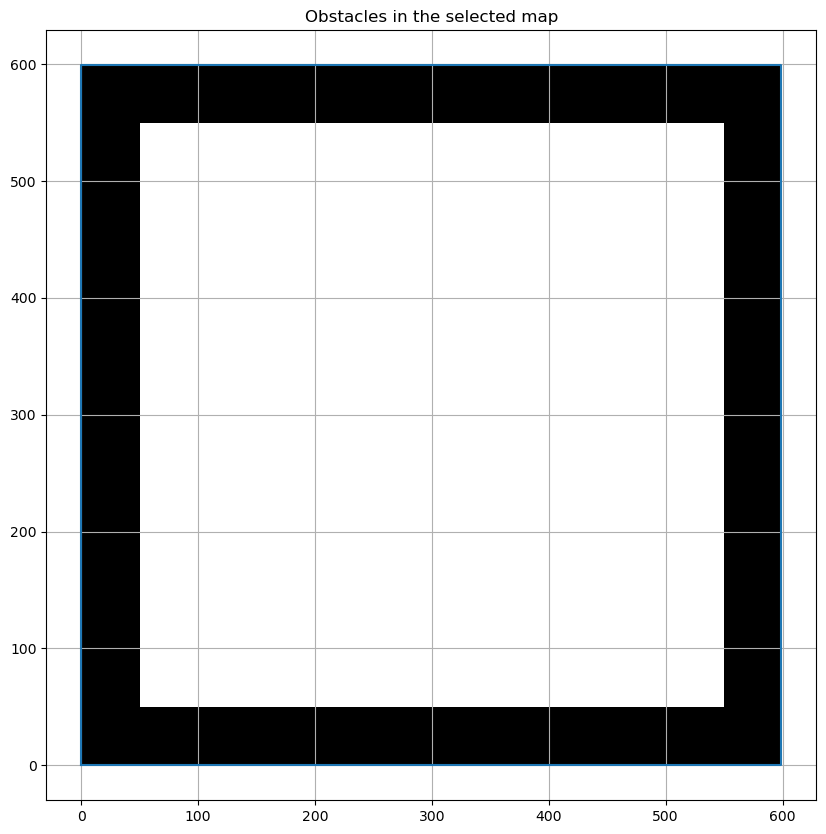

In [2]:
# Define global params
plt.rcParams['figure.figsize'] = [10, 10]

MAX_RANGE_ALL_METHODS = 600.0

# choose the map
SELECTED_MAP_PATH = BOX_MAP
SELECTED_OBSTACLES = BOX_MAP_OBSTACLES

# Show the obstacles in the map
plt.figure()
plt.title("Obstacles in the selected map")
plt.grid()
for poly in SELECTED_OBSTACLES:
    x, y = poly.exterior.xy
    plt.fill(x, y, "k")
plt.plot((0, 599, 599, 0, 0), (0, 0, 599, 599, 0))  # map borders
plt.gca().set_aspect('equal')
plt.show()

In [3]:
def batchCalcRangeAnglesAnalytic(obstacles, queryPoses, queryAngles):
    '''
    Computes the analytic range between a given set of obstacles and the query poses and 
    angles, akin to the rangelib methods.
    '''
    ret = []
    for pose in queryPoses.transpose():
        for angle in queryAngles:
            # get a line segment to compute intersection with
            p0 = shapely.Point((pose[0], pose[1]))
            dx = np.cos(pose[2] + angle) * 600
            dy = np.sin(pose[2] + angle) * 600
            p1 = shapely.Point((p0.x + dx, p0.y + dy))
            ray = shapely.LineString((p0, p1))

            range = MAX_RANGE_ALL_METHODS

            # Query the closest intersection point
            for obstacle in obstacles:
                intersections: shapely.LineString = ray.intersection(obstacle)
                for intersectionPt in intersections.coords:
                    intersectionRange = np.hypot(p0.x - intersectionPt[0],
                                                 p0.y - intersectionPt[1])

                    if intersectionRange < range:
                        range = intersectionRange

            ret.append(range)

    return np.array(ret, dtype=np.single)


def getGLTDiscretization(angle: float, discretization: int) -> int:
    # wrap angle to 2pi
    angle = angle % (2 * np.pi)
    assert angle >= 0.0 and angle < (2*np.pi)

    discretize_div_2pi = discretization / (2*np.pi)
    discretized_angle = angle * discretize_div_2pi

    rounded = np.round(discretized_angle, 0) % discretization

    assert rounded >= 0 and rounded < discretization

    return int(rounded)


def getGLTDiscretizationError(angle: float, discretization: int, discretized_angle: int) -> float:
    two_pi_div_discretize = (2*np.pi) / discretization
    undiscretized = discretized_angle * two_pi_div_discretize

    error = angle - undiscretized
    if error < 0:
        error += (np.pi * 2)

    if error > np.pi:
        error -= (np.pi * 2)

    assert error >= -np.pi, f"Got {angle=}, {undiscretized=}, {error=}"
    assert error <= np.pi, f"Got {angle=}, {undiscretized=}, {error=}"

    return error

In [4]:
# Setup the range methods
GLT_THETA_DISCRETIZATION = 181

testOMap = rangelib.OMap(SELECTED_MAP_PATH)
testDistanceTransform = rangelib.DistanceTransform(testOMap)
testBresenhams = rangelib.Bresenham(
    testDistanceTransform, MAX_RANGE_ALL_METHODS)
testRayMarching = rangelib.RayMarching(
    testDistanceTransform, MAX_RANGE_ALL_METHODS)
testGiantLookup = rangelib.GiantLUT(
    testDistanceTransform, MAX_RANGE_ALL_METHODS, GLT_THETA_DISCRETIZATION)

In [5]:
# define a grid of particle poses and query angles
queryX = np.linspace(200, 200, 1, endpoint=True)
queryY = np.linspace(400, 400, 1, endpoint=True)
queryTheta = np.linspace(0.0, 2*np.pi, 12, endpoint=False)

# make into np array that is acceptable by rangelib
queryList = []
for x in queryX:
    for y in queryY:
        for theta in queryTheta:
            queryList.append((x, y, theta))

queryPoses = np.array(queryList, dtype=np.single).transpose()

# define a grid of query angles
queryAngleTheta = np.linspace(np.radians(10.0), 2*np.pi, 1, endpoint=False)
queryAngles = np.array(queryAngleTheta, dtype=np.single)

print("Query Poses: ", queryList)
print("Query Angles: ", queryAngles)
for theta in queryTheta:
    for angle in queryAngles:
        eff_angle = theta + angle
        discretized_eff_angle = getGLTDiscretization(eff_angle, GLT_THETA_DISCRETIZATION)
        discretized_error = getGLTDiscretizationError(eff_angle, GLT_THETA_DISCRETIZATION, discretized_eff_angle)
        print(f"Original angle {np.degrees(eff_angle)} was wrapped to {discretized_eff_angle} with error {np.degrees(discretized_error)}")

analyticResults = batchCalcRangeAnglesAnalytic(
    SELECTED_OBSTACLES, queryPoses, queryAngles)
blResults = testBresenhams.batchCalcRangeAngles(queryPoses, queryAngles)
rmResults = testRayMarching.batchCalcRangeAngles(queryPoses, queryAngles)
gltResults = testGiantLookup.batchCalcRangeAngles(queryPoses, queryAngles)

Query Poses:  [(200.0, 400.0, 0.0), (200.0, 400.0, 0.5235987755982988), (200.0, 400.0, 1.0471975511965976), (200.0, 400.0, 1.5707963267948966), (200.0, 400.0, 2.0943951023931953), (200.0, 400.0, 2.617993877991494), (200.0, 400.0, 3.141592653589793), (200.0, 400.0, 3.665191429188092), (200.0, 400.0, 4.1887902047863905), (200.0, 400.0, 4.71238898038469), (200.0, 400.0, 5.235987755982988), (200.0, 400.0, 5.759586531581287)]
Query Angles:  [0.17453292]
Original angle 9.99999970909292 was wrapped to 5 with error 0.05524832787745112
Original angle 39.99999970909292 was wrapped to 20 with error 0.22099418423103911
Original angle 69.99999970909292 was wrapped to 35 with error 0.3867400405846271
Original angle 99.99999970909292 was wrapped to 50 with error 0.5524858969382215
Original angle 129.99999970909292 was wrapped to 65 with error 0.7182317532918158
Original angle 159.9999997090929 was wrapped to 80 with error 0.8839776096453846
Original angle 189.99999970909292 was wrapped to 96 with err

In [6]:
# parse the results
overallResults = {}

curr_pose_idx = 0
curr_angle_idx = 0
for analytic_res, bl_res, rm_res, glt_res in zip(analyticResults, blResults, rmResults, gltResults):
    curr_pose = queryList[curr_pose_idx]
    curr_angle = queryAngles[curr_angle_idx]
    curr_pose = (curr_pose[0], curr_pose[1], curr_pose[2] + curr_angle)

    if analytic_res < MAX_RANGE_ALL_METHODS:
        overallResults[curr_pose] = (analytic_res, bl_res, rm_res, glt_res)

    if (curr_angle_idx % len(queryAngles) == 0):
        curr_pose_idx += 1
        curr_angle_idx = 0

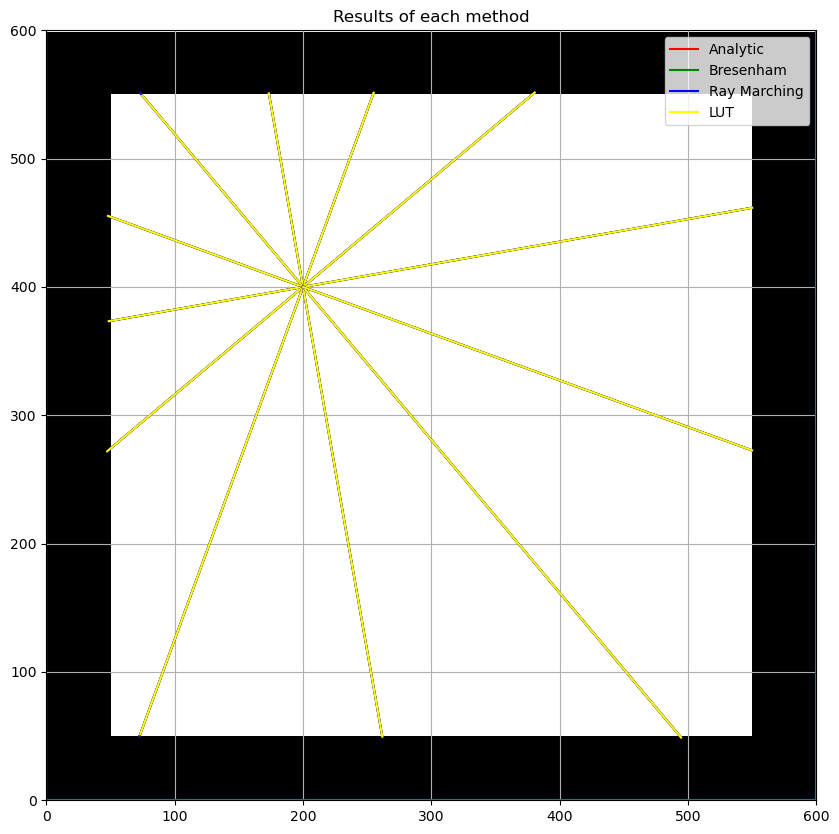

In [7]:
# Plot the results
plt.figure()
plt.title("Results of each method")
plt.grid()
for poly in SELECTED_OBSTACLES:
    x, y = poly.exterior.xy
    plt.fill(x, y, "k")
plt.plot((0, 600, 600, 0, 0), (0, 0, 600, 600, 0))  # map borders

metadata = [
    ('red', "Analytic"),
    ('green', "Bresenham"),
    ('blue', "Ray Marching"),
    ('yellow', "LUT")
]

first = True
for pose, distances in overallResults.items():
    x = pose[0]
    y = pose[1]
    eff_angle = pose[2]
    plt.scatter(x, y, marker='o', color='red')

    for dist, meta in zip(distances, metadata):
        dx = np.cos(eff_angle) * dist
        dy = np.sin(eff_angle) * dist

        plt.plot((x, x+dx), (y, y+dy),
                 color=meta[0], label=meta[1] if first else None)
    first = False

plt.legend()
plt.xlim((0, 600))
plt.ylim((0, 600))
plt.gca().set_aspect('equal')
plt.show()

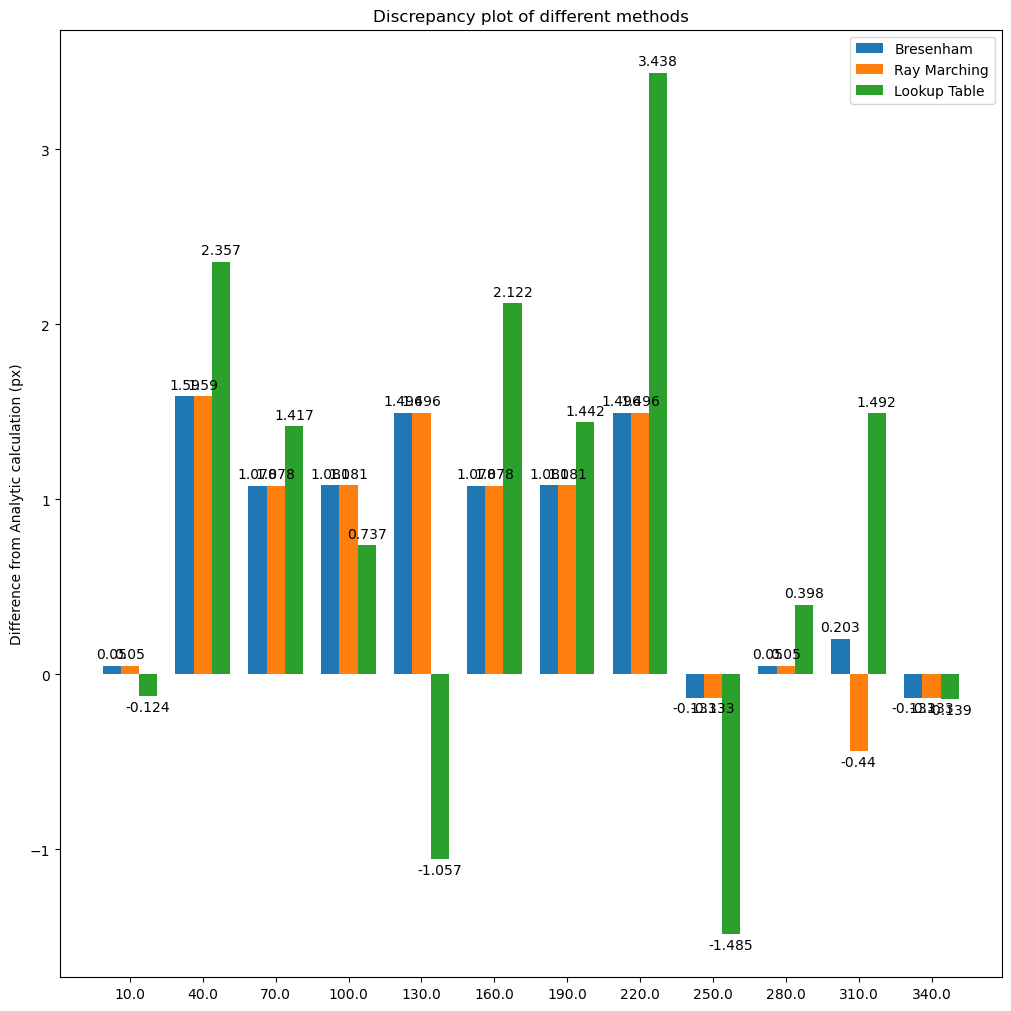

In [8]:
# Plot results for elements with a collision

methods = ("Bresenham", "Ray Marching", "Lookup Table")

plot_results = {}
nonzero_angles = [np.degrees(pose[2]).round(3)
                  for pose in overallResults.keys()]
nonzero_angles = list(dict.fromkeys(nonzero_angles))  # remove duplicates

discrepancies = {
    'Bresenham': [r[1]-r[0] for r in overallResults.values()],
    'Ray Marching': [r[2]-r[0] for r in overallResults.values()],
    'Lookup Table': [r[3]-r[0] for r in overallResults.values()],
}

# Take the average of each discrepacy as they are repeated
for disc_key in discrepancies.keys():
    num_repeats = len(discrepancies[disc_key]) // len(nonzero_angles)
    temp = []
    for i in range(len(nonzero_angles)):
        only_one_angle = discrepancies[disc_key][i::len(nonzero_angles)]
        assert len(only_one_angle) == num_repeats

        angle_average_val = sum(only_one_angle)/len(only_one_angle)
        angle_average_val = np.round(angle_average_val, 3)

        temp.append(angle_average_val)

    discrepancies[disc_key] = temp

x = np.arange(len(nonzero_angles))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in discrepancies.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difference from Analytic calculation (px)')
ax.set_title('Discrepancy plot of different methods')
ax.set_xticks(x + width, nonzero_angles)
ax.legend(loc='upper right')

plt.show()

### Investigating the effect of $\theta$ discretization on range accuracy

We would like to investigate the effect of range methods on the accuracy of the estimate when using the Giant Lookup Table method.

To do this, we can vary the value of the `theta_discretization` parameter and feed discretized angles to the Ray Marching query function -- this is the same way a Lookup Table is constructed under the hood.

As the error originates from an approximation of the angle, it is compounded by differences in the actual range. Therefore, we shall hold the ground-truth distance constant at 100 pixels, and vary the query poses such that they will always read this value.

We test 4 target points on the map, with a range of target values. These are displayed in the below map.

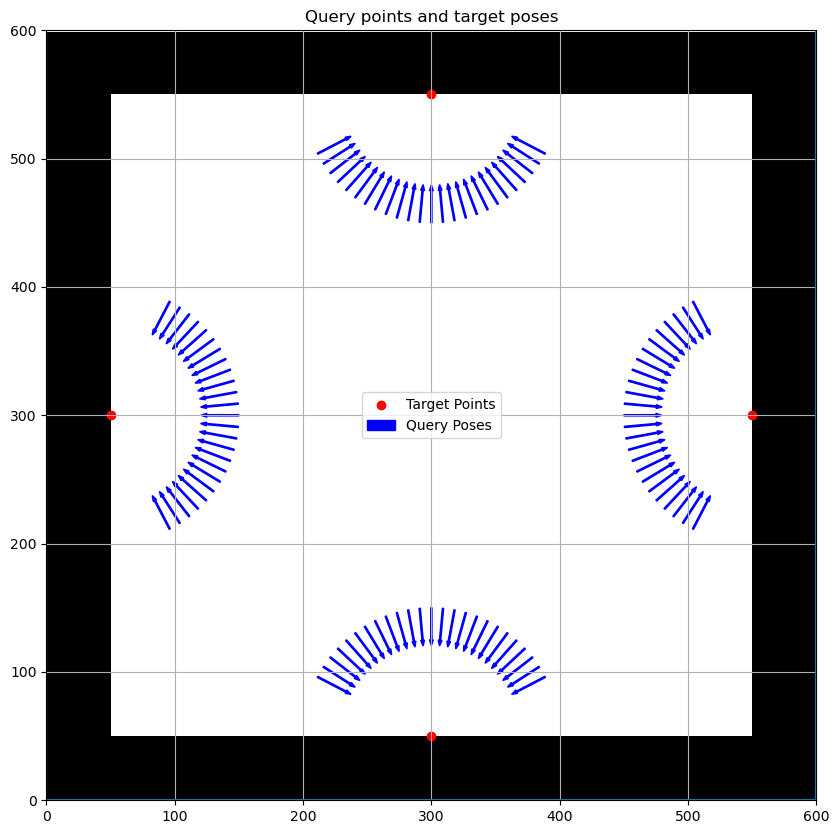

In [14]:
target_points_to_query_poses = {
    (50, 300): [],
    (300, 50): [],
    (550, 300): [],
    (300, 550): [],
}

num_query_points = 25
query_distance = 100

x, y = zip(*target_points_to_query_poses.keys())

query_angle = np.radians(125)
# This increases from 0, 90, 180, 270 deg depending on the side of the square
start_angle = 0.0

for target_point in target_points_to_query_poses:
    query_x, query_y = target_point

    query_angles = np.linspace(
        start_angle-query_angle/2, start_angle+query_angle/2, num_query_points, endpoint=True)

    for angle in query_angles:
        # The vector should point back in towards the target point, hence +180deg (then rectify)
        rectifed_angle = angle + np.pi
        rectifed_angle = np.arctan2(
            np.sin(rectifed_angle), np.cos(rectifed_angle))

        curr_coord = (
            query_x + np.cos(angle) * query_distance,
            query_y + np.sin(angle) * query_distance,
            angle + np.pi
        )
        target_points_to_query_poses[target_point].append(curr_coord)

    start_angle += np.pi/2  # This is hardcoded to the square map


# Plot the query points as well as the query poses
plt.figure()
plt.title("Query points and target poses")
plt.grid()
for poly in SELECTED_OBSTACLES:
    x, y = poly.exterior.xy
    plt.fill(x, y, "k")
plt.plot((0, 600, 600, 0, 0), (0, 0, 600, 600, 0))  # map borders

# Plot the query points
target_x, target_y = zip(*target_points_to_query_poses.keys())
plt.scatter(target_x, target_y, marker="o", color="red", label="Target Points")

first = True
for query_poses in target_points_to_query_poses.values():
    for query_pose in query_poses:
        x = query_pose[0]
        y = query_pose[1]
        theta = query_pose[2]
        dx = 25*np.cos(theta)
        dy = 25*np.sin(theta)

        plt.arrow(x, y, dx, dy, color="blue", width=1.0,
                  label="Query Poses" if first else None)
        first = False

plt.legend()
plt.xlim((0, 600))
plt.ylim((0, 600))
plt.gca().set_aspect('equal')
plt.show()

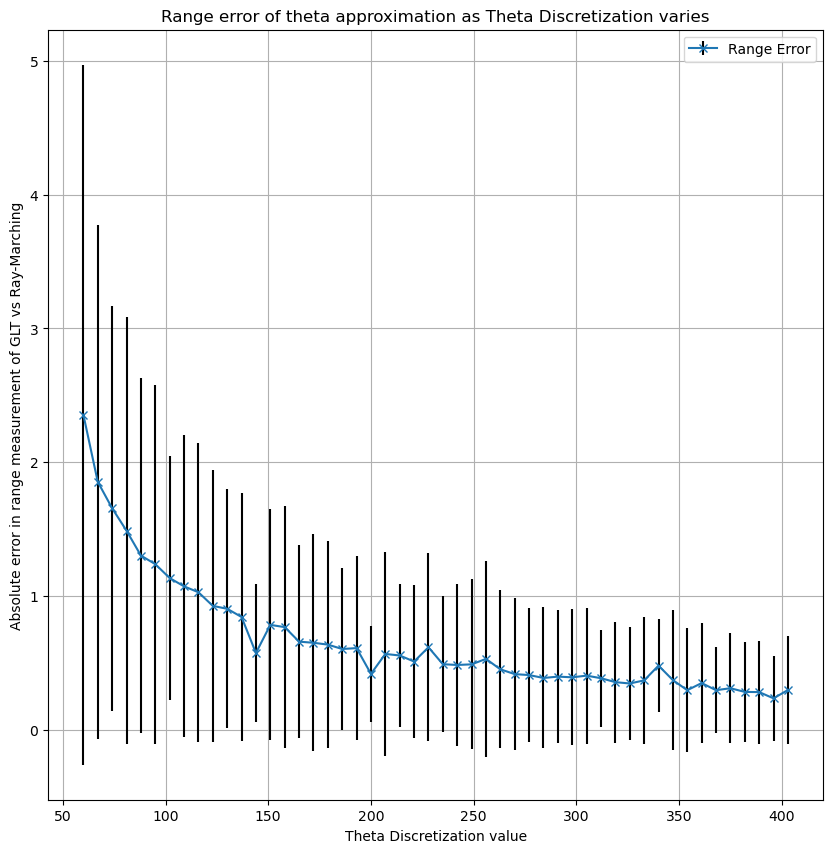

In [17]:
# Calculate the input queries

query_theta_disc_start = 60
query_theta_disc_step = 7
query_theta_disc_num = 50
query_theta_discretizations = np.arange(
    query_theta_disc_start,
    query_theta_disc_start + query_theta_disc_num * query_theta_disc_step,
    query_theta_disc_step
)

query_angles = np.array([0.0], dtype=np.single)
discretizeation_errors = []
range_errors = []

for query_theta_discretization in query_theta_discretizations:

    discretizeation_errors_acc = []
    range_errors_acc = []
    two_pi_div_discretize = (2*np.pi) / query_theta_discretization

    for query_poses in target_points_to_query_poses.values():
        query_poses_disc = []
        for query_pose in query_poses:
            discretized_eff_angle = getGLTDiscretization(
                query_pose[2], query_theta_discretization)
            discretized_error = getGLTDiscretizationError(
                query_pose[2], query_theta_discretization, discretized_eff_angle)
            discretized_angle_backward = discretized_eff_angle * two_pi_div_discretize

            discretizeation_errors_acc.append(np.abs(discretized_error))
            query_poses_disc.append(
                (query_pose[0], query_pose[1], discretized_angle_backward))

        query_poses = np.array(query_poses, dtype=np.single).transpose()
        query_poses_disc = np.array(
            query_poses_disc, dtype=np.single).transpose()

        # Compute ranges
        range_results = testRayMarching.batchCalcRangeAngles(
            query_poses, query_angles)
        disc_results = testRayMarching.batchCalcRangeAngles(
            query_poses_disc, query_angles)

        range_errors_acc += list(np.abs(range_results - disc_results))

    # Compute statistics over discretization error
    mean_disc_err = np.mean(discretizeation_errors_acc)
    std_disc_err = np.std(discretizeation_errors_acc)
    discretizeation_errors.append((mean_disc_err, std_disc_err))

    # Compute statistics over range error
    range_errors.append((
        np.mean(range_errors_acc),
        np.std(range_errors_acc)
    ))

assert len(
    range_errors) == query_theta_disc_num, f"{len(range_errors)=}, {query_theta_disc_num=}"
assert len(
    discretizeation_errors) == query_theta_disc_num, f"{len(discretizeation_errors)=}, {query_theta_disc_num=}"

range_errors_mean, range_errors_std = zip(*range_errors)
discretization_errors_mean, discretization_errors_std = zip(
    *discretizeation_errors)


plt.figure()
plt.errorbar(query_theta_discretizations, range_errors_mean,
             yerr=range_errors_std, fmt="x-",
             ecolor='k', label="Range Error")
plt.title("Range error of theta approximation as Theta Discretization varies")
plt.xlabel("Theta Discretization value")
plt.ylabel("Absolute error in range measurement of GLT vs Ray-Marching")
plt.grid()
plt.legend()
plt.show()

A sensible value to choose for theta-discretization might therefore be 200.